# GameTheory-10-BayesianGames

## Jeux Bayesiens : Information Incomplete et Croyances

Ce notebook introduit les **jeux bayesiens** ou les joueurs ont une incertitude sur les caracteristiques des autres (types, gains, strategies disponibles).

### Objectifs

1. Comprendre la distinction information **imparfaite** vs **incomplete**
2. Maitriser le concept de **type** et de **croyance**
3. Definir et calculer l'**equilibre bayesien de Nash**
4. Analyser des jeux classiques : Cournot incertain, encheres
5. Introduire les **jeux de signaling**

### Prerequis

- Notebooks 1-9 : Fondations et jeux extensifs
- Notions de base en probabilites (Bayes)

In [1]:
# Configuration et imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Callable
from collections import defaultdict
import itertools

# Style matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

## 1. Information Imparfaite vs Incomplete

### 1.1 Distinction Fondamentale

| Type | Description | Exemple |
|------|-------------|----------|
| **Imparfaite** | Incertitude sur les **actions** jouees | Poker: je ne vois pas tes cartes jouees |
| **Incomplete** | Incertitude sur les **caracteristiques** du jeu | Je ne connais pas ta fonction de gain |

### 1.2 Transformation de Harsanyi

Harsanyi (1967-68) a montre comment transformer un jeu a information incomplete en jeu a information imparfaite :

1. Introduire des **types** pour chaque joueur (caracteristiques privees)
2. Ajouter un joueur **Nature** qui tire les types selon une distribution commune
3. Chaque joueur observe son propre type mais pas celui des autres
4. Le jeu devient a information imparfaite (sur les types)

In [2]:
# Structure de base pour les jeux bayesiens

@dataclass
class BayesianGame:
    """Representation d'un jeu bayesien."""
    
    name: str
    players: List[str]
    types: Dict[str, List[str]]  # player -> liste de types possibles
    prior: Dict[Tuple, float]  # (type1, type2, ...) -> probabilite
    actions: Dict[str, List[str]]  # player -> liste d'actions
    payoffs: Callable  # (type_profile, action_profile) -> payoff_profile
    
    def __post_init__(self):
        # Verifier que le prior est une distribution
        total = sum(self.prior.values())
        assert abs(total - 1.0) < 1e-6, f"Prior doit sommer a 1, got {total}"
    
    def get_conditional_prob(self, player: str, player_type: str, other_types: Tuple) -> float:
        """
        Calcule P(autres types | mon type) par Bayes.
        """
        player_idx = self.players.index(player)
        
        # Numerateur: P(type_profile)
        full_types = list(other_types)
        full_types.insert(player_idx, player_type)
        numerator = self.prior.get(tuple(full_types), 0)
        
        # Denominateur: P(mon type) = sum sur autres types
        denominator = 0
        other_players = [p for p in self.players if p != player]
        for other_combo in itertools.product(*[self.types[p] for p in other_players]):
            full = list(other_combo)
            full.insert(player_idx, player_type)
            denominator += self.prior.get(tuple(full), 0)
        
        if denominator == 0:
            return 0
        return numerator / denominator


def display_bayesian_game(game: BayesianGame):
    """Affiche les caracteristiques d'un jeu bayesien."""
    print(f"\nJeu Bayesien: {game.name}")
    print("="*50)
    print(f"Joueurs: {game.players}")
    print(f"Types: {game.types}")
    print(f"Actions: {game.actions}")
    print(f"\nDistribution a priori:")
    for types, prob in game.prior.items():
        if prob > 0:
            print(f"  P{types} = {prob:.3f}")

## 2. Equilibre Bayesien de Nash

### 2.1 Definition

Un **equilibre bayesien de Nash (BNE)** est un profil de strategies $\sigma = (\sigma_1, ..., \sigma_n)$ ou chaque $\sigma_i$ est une fonction $\sigma_i: T_i \to \Delta(A_i)$ qui specifie une strategie mixte pour chaque type du joueur $i$.

Le profil $\sigma$ est un BNE si pour tout joueur $i$ et tout type $t_i \in T_i$ :

$$\sigma_i(t_i) \in \arg\max_{a_i \in A_i} \sum_{t_{-i}} P(t_{-i}|t_i) \cdot u_i(a_i, \sigma_{-i}(t_{-i}), t_i, t_{-i})$$

### 2.2 Interpretation

- Chaque type de chaque joueur maximise son gain **espere**
- L'esperance est prise sur les types des autres (conditionnellement au sien)
- Les autres sont supposes jouer selon leur strategie d'equilibre

In [3]:
def compute_expected_payoff(game: BayesianGame, 
                            player: str, 
                            player_type: str,
                            player_action: str,
                            strategies: Dict[str, Dict[str, str]]) -> float:
    """
    Calcule le gain espere d'un joueur pour une action donnee.
    
    strategies: {player: {type: action}} - strategies pures des autres
    """
    player_idx = game.players.index(player)
    other_players = [p for p in game.players if p != player]
    
    expected = 0
    
    # Sommer sur tous les profils de types des autres
    for other_types in itertools.product(*[game.types[p] for p in other_players]):
        # Probabilite conditionnelle
        prob = game.get_conditional_prob(player, player_type, other_types)
        if prob == 0:
            continue
        
        # Actions des autres selon leurs strategies
        other_actions = [strategies[p][t] for p, t in zip(other_players, other_types)]
        
        # Profil complet de types et actions
        all_types = list(other_types)
        all_types.insert(player_idx, player_type)
        
        all_actions = list(other_actions)
        all_actions.insert(player_idx, player_action)
        
        # Gain
        payoffs = game.payoffs(tuple(all_types), tuple(all_actions))
        expected += prob * payoffs[player_idx]
    
    return expected


def is_bayesian_nash_equilibrium(game: BayesianGame,
                                  strategies: Dict[str, Dict[str, str]]) -> bool:
    """
    Verifie si un profil de strategies pures est un BNE.
    """
    for player in game.players:
        for player_type in game.types[player]:
            current_action = strategies[player][player_type]
            current_payoff = compute_expected_payoff(
                game, player, player_type, current_action, strategies
            )
            
            # Verifier qu'aucune deviation n'est profitable
            for alt_action in game.actions[player]:
                if alt_action == current_action:
                    continue
                alt_payoff = compute_expected_payoff(
                    game, player, player_type, alt_action, strategies
                )
                if alt_payoff > current_payoff + 1e-6:
                    return False
    
    return True

## 3. Exemple: Bataille des Sexes avec Incertitude

Bataille des sexes ou J1 ne sait pas si J2 est de type "Opera lover" ou "Football lover".

In [4]:
def create_uncertain_bos():
    """
    Bataille des Sexes avec incertitude sur J2.
    
    J1: type unique (pas d'incertitude sur lui)
    J2: type O (prefere Opera) avec proba p, type F (prefere Foot) avec proba 1-p
    
    Gains standards BoS:
    - Si memes choix: (2,1) si Opera, (1,2) si Foot
    - Si differents: (0,0)
    
    Mais pour J2 type F, les preferences sont inversees.
    """
    def payoffs(types, actions):
        """Calcule les gains."""
        _, t2 = types
        a1, a2 = actions
        
        if a1 == a2:
            if a1 == 'O':  # Tous a l'Opera
                if t2 == 'O':  # J2 prefere Opera
                    return (2, 1)
                else:  # J2 prefere Foot
                    return (2, 0)  # J2 moins content
            else:  # Tous au Foot
                if t2 == 'F':  # J2 prefere Foot
                    return (1, 2)
                else:  # J2 prefere Opera
                    return (1, 0)  # J2 moins content
        else:
            return (0, 0)
    
    p = 0.7  # Proba que J2 prefere Opera
    
    game = BayesianGame(
        name="BoS with Uncertainty",
        players=['J1', 'J2'],
        types={'J1': ['N'], 'J2': ['O', 'F']},  # J1 a un type unique
        prior={('N', 'O'): p, ('N', 'F'): 1-p},
        actions={'J1': ['O', 'F'], 'J2': ['O', 'F']},
        payoffs=payoffs
    )
    
    return game, p


bos_game, p = create_uncertain_bos()
display_bayesian_game(bos_game)

print(f"\nProbabilite que J2 prefere Opera: p = {p}")


Jeu Bayesien: BoS with Uncertainty
Joueurs: ['J1', 'J2']
Types: {'J1': ['N'], 'J2': ['O', 'F']}
Actions: {'J1': ['O', 'F'], 'J2': ['O', 'F']}

Distribution a priori:
  P('N', 'O') = 0.700
  P('N', 'F') = 0.300

Probabilite que J2 prefere Opera: p = 0.7


In [5]:
# Trouver les equilibres bayesiens

def find_bne_bos(game, p):
    """Trouve les BNE du BoS avec incertitude."""
    print("\nRecherche des equilibres bayesiens de Nash")
    print("="*50)
    
    # Enumerer toutes les strategies pures possibles
    # J1: une action
    # J2: une action pour chaque type
    
    equilibria = []
    
    for a1 in game.actions['J1']:
        for a2_O in game.actions['J2']:
            for a2_F in game.actions['J2']:
                strategies = {
                    'J1': {'N': a1},
                    'J2': {'O': a2_O, 'F': a2_F}
                }
                
                if is_bayesian_nash_equilibrium(game, strategies):
                    # Calculer les gains esperes
                    u1 = compute_expected_payoff(game, 'J1', 'N', a1, strategies)
                    u2_O = compute_expected_payoff(game, 'J2', 'O', a2_O, strategies)
                    u2_F = compute_expected_payoff(game, 'J2', 'F', a2_F, strategies)
                    
                    equilibria.append({
                        'strategies': strategies,
                        'u1': u1,
                        'u2_O': u2_O,
                        'u2_F': u2_F
                    })
    
    for i, eq in enumerate(equilibria, 1):
        print(f"\nBNE #{i}:")
        print(f"  J1: joue {eq['strategies']['J1']['N']}")
        print(f"  J2 type O: joue {eq['strategies']['J2']['O']}")
        print(f"  J2 type F: joue {eq['strategies']['J2']['F']}")
        print(f"  Gains esperes: J1={eq['u1']:.2f}, J2(O)={eq['u2_O']:.2f}, J2(F)={eq['u2_F']:.2f}")
    
    return equilibria

equilibria = find_bne_bos(bos_game, p)


Recherche des equilibres bayesiens de Nash

BNE #1:
  J1: joue O
  J2 type O: joue O
  J2 type F: joue O
  Gains esperes: J1=2.00, J2(O)=1.00, J2(F)=0.00

BNE #2:
  J1: joue O
  J2 type O: joue O
  J2 type F: joue F
  Gains esperes: J1=1.40, J2(O)=1.00, J2(F)=0.00

BNE #3:
  J1: joue F
  J2 type O: joue F
  J2 type F: joue F
  Gains esperes: J1=1.00, J2(O)=0.00, J2(F)=2.00


### Analyse des equilibres bayesiens

Les resultats ci-dessus illustrent plusieurs phenomenes importants :

**BNE #1 et #3 : Equilibres de coordination**
- Dans BNE #1, tout le monde va a l'Opera (meme le type F qui prefere Foot !)
- Dans BNE #3, tout le monde va au Foot
- Ce sont des equilibres "pooling" ou le type de J2 ne change pas son comportement

**BNE #2 : Equilibre separateur**
- Le type O joue Opera, le type F joue Foot
- Chaque type joue selon ses vraies preferences
- J1 joue Opera car p=0.7 (il anticipe plus souvent Opera)

**Pourquoi le BNE #2 existe-t-il ?**
- J1 joue Opera → gain = 0.7×2 + 0.3×0 = 1.4 avec la strategie separatrice de J2
- Si J1 jouait Foot → gain = 0.7×0 + 0.3×1 = 0.3
- Donc J1 prefere Opera, ce qui valide les croyances !

**Observation cle** : Le gain de J2 type F est **0** dans les BNE #1 et #2 ! Il est force de jouer contre ses preferences car J1 joue majoritairement Opera. C'est le "cout" d'etre un type minoritaire.

## 4. Cournot avec Couts Incertains

### 4.1 Le Modele

Duopole de Cournot ou chaque firme ne connait que son propre cout marginal.

- Firme $i$ a un cout $c_i \in \{c_L, c_H\}$
- Prix: $P(Q) = a - Q$ ou $Q = q_1 + q_2$
- Profit: $\pi_i = (P - c_i) q_i$

### 4.2 Strategie d'Equilibre

Chaque firme doit choisir une quantite pour chacun de ses types possibles: $q_i(c_i)$.

In [6]:
def solve_cournot_bayesian(a=100, c_L=10, c_H=30, prob_L=0.5):
    """
    Resout le duopole de Cournot avec couts incertains.
    
    Chaque firme peut avoir cout c_L (proba prob_L) ou c_H.
    Les types sont independants.
    """
    print("Cournot avec Couts Incertains")
    print("="*50)
    print(f"Demande: P = {a} - Q")
    print(f"Couts: c_L = {c_L}, c_H = {c_H}")
    print(f"P(c_L) = {prob_L}")
    
    # Variables: q_L (quantite si cout bas), q_H (quantite si cout haut)
    # Par symetrie, les deux firmes ont la meme strategie
    
    # FOC pour firme 1 de type L:
    # max_q1L E[(a - q1L - q2 - c_L) * q1L]
    # = max_q1L [(a - q1L - E[q2] - c_L) * q1L]
    # ou E[q2] = prob_L * q_L + (1-prob_L) * q_H
    
    # FOC: a - 2*q_L - E[q] - c_L = 0
    # Symetrie: q_L = q_L(autre), q_H = q_H(autre)
    # Donc E[q] = prob_L * q_L + (1-prob_L) * q_H
    
    # Systeme:
    # a - 2*q_L - (prob_L*q_L + (1-prob_L)*q_H) - c_L = 0
    # a - 2*q_H - (prob_L*q_L + (1-prob_L)*q_H) - c_H = 0
    
    def equations(x):
        q_L, q_H = x
        E_q = prob_L * q_L + (1 - prob_L) * q_H
        eq1 = a - 2*q_L - E_q - c_L
        eq2 = a - 2*q_H - E_q - c_H
        return [eq1, eq2]
    
    solution = fsolve(equations, [30, 20])
    q_L, q_H = solution
    
    print("\n" + "="*50)
    print("Solution du BNE (par firme):")
    print(f"  q(c_L) = {q_L:.2f}")
    print(f"  q(c_H) = {q_H:.2f}")
    
    # Gains esperes
    E_q = prob_L * q_L + (1 - prob_L) * q_H
    
    # Prix selon les realisation de couts
    combos = [(c_L, c_L), (c_L, c_H), (c_H, c_L), (c_H, c_H)]
    probs_combo = [prob_L**2, prob_L*(1-prob_L), (1-prob_L)*prob_L, (1-prob_L)**2]
    
    print("\nScenarios possibles:")
    for (c1, c2), prob in zip(combos, probs_combo):
        q1 = q_L if c1 == c_L else q_H
        q2 = q_L if c2 == c_L else q_H
        P = a - q1 - q2
        pi1 = (P - c1) * q1
        pi2 = (P - c2) * q2
        print(f"  (c1={c1}, c2={c2}) prob={prob:.2f}: P={P:.1f}, pi1={pi1:.1f}, pi2={pi2:.1f}")
    
    return q_L, q_H

q_L, q_H = solve_cournot_bayesian()

Cournot avec Couts Incertains
Demande: P = 100 - Q
Couts: c_L = 10, c_H = 30
P(c_L) = 0.5

Solution du BNE (par firme):
  q(c_L) = 31.67
  q(c_H) = 21.67

Scenarios possibles:
  (c1=10, c2=10) prob=0.25: P=36.7, pi1=844.4, pi2=844.4
  (c1=10, c2=30) prob=0.25: P=46.7, pi1=1161.1, pi2=361.1
  (c1=30, c2=10) prob=0.25: P=46.7, pi1=361.1, pi2=1161.1
  (c1=30, c2=30) prob=0.25: P=56.7, pi1=577.8, pi2=577.8


/tmp/ipykernel_6178/2051189024.py:37: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, [30, 20])


In [7]:
# Comparaison avec Cournot complet

def compare_cournot_complete_incomplete():
    """Compare les solutions avec et sans information complete."""
    a, c_L, c_H = 100, 10, 30
    
    print("Comparaison: Information Complete vs Incomplete")
    print("="*60)
    
    # Information complete: les deux couts sont connus
    print("\n1. Information complete:")
    for c1, c2 in [(c_L, c_L), (c_L, c_H), (c_H, c_H)]:
        # Nash: q_i = (a - 2*c_i + c_j) / 3
        q1 = (a - 2*c1 + c2) / 3
        q2 = (a - 2*c2 + c1) / 3
        P = a - q1 - q2
        print(f"  (c1={c1}, c2={c2}): q1={q1:.1f}, q2={q2:.1f}, P={P:.1f}")
    
    # Information incomplete
    print("\n2. Information incomplete (prob_L=0.5):")
    q_L, q_H = solve_cournot_bayesian(prob_L=0.5)
    
    print("\n" + "="*60)
    print("\nObservations:")
    print("  - Avec info incomplete, les quantites sont differentes")
    print("  - Le type a cout bas produit MOINS qu'avec info complete")
    print("    (car il anticipe un adversaire potentiellement inefficace)")
    print("  - Le type a cout haut produit PLUS qu'avec info complete")
    print("    (car il anticipe un adversaire potentiellement efficace)")

compare_cournot_complete_incomplete()

Comparaison: Information Complete vs Incomplete

1. Information complete:
  (c1=10, c2=10): q1=30.0, q2=30.0, P=40.0
  (c1=10, c2=30): q1=36.7, q2=16.7, P=46.7
  (c1=30, c2=30): q1=23.3, q2=23.3, P=53.3

2. Information incomplete (prob_L=0.5):
Cournot avec Couts Incertains
Demande: P = 100 - Q
Couts: c_L = 10, c_H = 30
P(c_L) = 0.5

Solution du BNE (par firme):
  q(c_L) = 31.67
  q(c_H) = 21.67

Scenarios possibles:
  (c1=10, c2=10) prob=0.25: P=36.7, pi1=844.4, pi2=844.4
  (c1=10, c2=30) prob=0.25: P=46.7, pi1=1161.1, pi2=361.1
  (c1=30, c2=10) prob=0.25: P=46.7, pi1=361.1, pi2=1161.1
  (c1=30, c2=30) prob=0.25: P=56.7, pi1=577.8, pi2=577.8


Observations:
  - Avec info incomplete, les quantites sont differentes
  - Le type a cout bas produit MOINS qu'avec info complete
    (car il anticipe un adversaire potentiellement inefficace)
  - Le type a cout haut produit PLUS qu'avec info complete
    (car il anticipe un adversaire potentiellement efficace)


/tmp/ipykernel_6178/2051189024.py:37: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, [30, 20])


## 5. Encheres a Valeurs Privees

### 5.1 Enchere au Premier Prix

- Chaque encherisseur $i$ a une **valuation privee** $v_i \sim U[0,1]$
- Chacun soumet une offre $b_i$ simultanement
- Le plus offrant gagne et paie son offre
- Gain du gagnant: $v_i - b_i$, perdants: $0$

### 5.2 Equilibre Bayesien

Dans l'enchere au premier prix avec $n$ encherisseurs et valuations $U[0,1]$ :

$$b^*(v) = \frac{n-1}{n} v$$

Les joueurs **sous-declarent** leurs valuations pour extraire un surplus.

In [8]:
def analyze_first_price_auction(n=2, n_simulations=10000):
    """
    Analyse de l'enchere au premier prix.
    """
    print(f"Enchere au Premier Prix avec {n} encherisseurs")
    print("="*50)
    print(f"Valuations: v_i ~ U[0,1] independantes")
    print(f"Strategie d'equilibre: b(v) = {(n-1)/n:.3f} * v")
    
    # Fonction de meilleure offre
    def optimal_bid(v):
        return (n - 1) / n * v
    
    # Simulation
    revenues = []
    winner_surpluses = []
    efficiencies = []
    
    for _ in range(n_simulations):
        # Tirer les valuations
        values = np.random.uniform(0, 1, n)
        
        # Offres selon la strategie d'equilibre
        bids = optimal_bid(values)
        
        # Gagnant
        winner = np.argmax(bids)
        winning_bid = bids[winner]
        
        # Metriques
        revenues.append(winning_bid)
        winner_surpluses.append(values[winner] - winning_bid)
        
        # Efficacite: le bien va-t-il au plus offrant en termes de valuation?
        highest_value_bidder = np.argmax(values)
        efficiencies.append(1 if winner == highest_value_bidder else 0)
    
    print("\n" + "="*50)
    print(f"Resultats de simulation ({n_simulations} encheres):")
    print(f"  Revenue moyen du vendeur: {np.mean(revenues):.4f}")
    print(f"  Surplus moyen du gagnant: {np.mean(winner_surpluses):.4f}")
    print(f"  Efficacite (bien va au plus valuant): {np.mean(efficiencies)*100:.1f}%")
    
    # Formule theorique pour n=2: E[revenue] = 1/3
    print(f"\n  Revenu theorique (formule): {(n-1)/(n+1):.4f}")
    
    return revenues, winner_surpluses

revenues_2, surpluses_2 = analyze_first_price_auction(n=2)

Enchere au Premier Prix avec 2 encherisseurs
Valuations: v_i ~ U[0,1] independantes
Strategie d'equilibre: b(v) = 0.500 * v

Resultats de simulation (10000 encheres):
  Revenue moyen du vendeur: 0.3330
  Surplus moyen du gagnant: 0.3330
  Efficacite (bien va au plus valuant): 100.0%

  Revenu theorique (formule): 0.3333


In [9]:
# Comparaison premier prix vs second prix (Vickrey)

def compare_auction_formats():
    """Compare les formats d'enchere."""
    print("Comparaison: Premier Prix vs Second Prix (Vickrey)")
    print("="*60)
    
    n_values = [2, 3, 5, 10]
    n_sims = 5000
    
    results = []
    
    for n in n_values:
        # Premier prix
        rev_1st = []
        rev_2nd = []
        
        for _ in range(n_sims):
            values = np.random.uniform(0, 1, n)
            
            # Premier prix: b(v) = (n-1)/n * v
            bids_1st = (n-1)/n * values
            rev_1st.append(np.max(bids_1st))
            
            # Second prix: b(v) = v (verite dominante)
            sorted_vals = np.sort(values)[::-1]
            rev_2nd.append(sorted_vals[1])  # Deuxieme plus haute valuation
        
        results.append({
            'n': n,
            'first_price': np.mean(rev_1st),
            'second_price': np.mean(rev_2nd),
            'theoretical': (n-1)/(n+1)
        })
    
    print(f"\n{'n':>4} {'1er prix':>12} {'2e prix':>12} {'Theorie':>12}")
    print("-"*44)
    for r in results:
        print(f"{r['n']:>4} {r['first_price']:>12.4f} {r['second_price']:>12.4f} {r['theoretical']:>12.4f}")
    
    print("\n" + "="*60)
    print("\nTheoreme d'equivalence du revenu:")
    print("  Les deux formats donnent le MEME revenu espere au vendeur!")
    print("  (pour encherisseurs neutres au risque, valuations i.i.d.)")

compare_auction_formats()

Comparaison: Premier Prix vs Second Prix (Vickrey)

   n     1er prix      2e prix      Theorie
--------------------------------------------
   2       0.3324       0.3354       0.3333
   3       0.4994       0.4973       0.5000
   5       0.6665       0.6699       0.6667
  10       0.8175       0.8186       0.8182


Theoreme d'equivalence du revenu:
  Les deux formats donnent le MEME revenu espere au vendeur!
  (pour encherisseurs neutres au risque, valuations i.i.d.)


### Le theoreme d'equivalence du revenu

Les resultats des simulations confirment un resultat fondamental de la theorie des encheres :

**Theoreme (Equivalence du revenu)** :
Pour des encherisseurs neutres au risque avec valuations i.i.d., tous les formats d'enchere standards (premier prix, second prix, anglais, hollandais) donnent le **meme revenu espere** au vendeur.

**Intuition** :
- **Second prix** : Les gens revelent leur vraie valeur, le gagnant paie la 2eme plus haute
- **Premier prix** : Les gens sous-declarent, mais le gagnant paie sa propre offre (plus haute)
- Ces deux effets se compensent exactement !

**Formule du revenu** :

$$E[R] = E[v^{(2)}] = \frac{n-1}{n+1}$$

ou $v^{(2)}$ est la 2eme statistique d'ordre des valuations.

**Implications pratiques** :
- Pour un vendeur neutre au risque, le choix du format n'importe pas (en theorie)
- En pratique, les differences apparaissent avec : aversion au risque, collusion, valeurs correlees, etc.
- Le second prix (Vickrey) est souvent prefere car "dire la verite" est plus simple

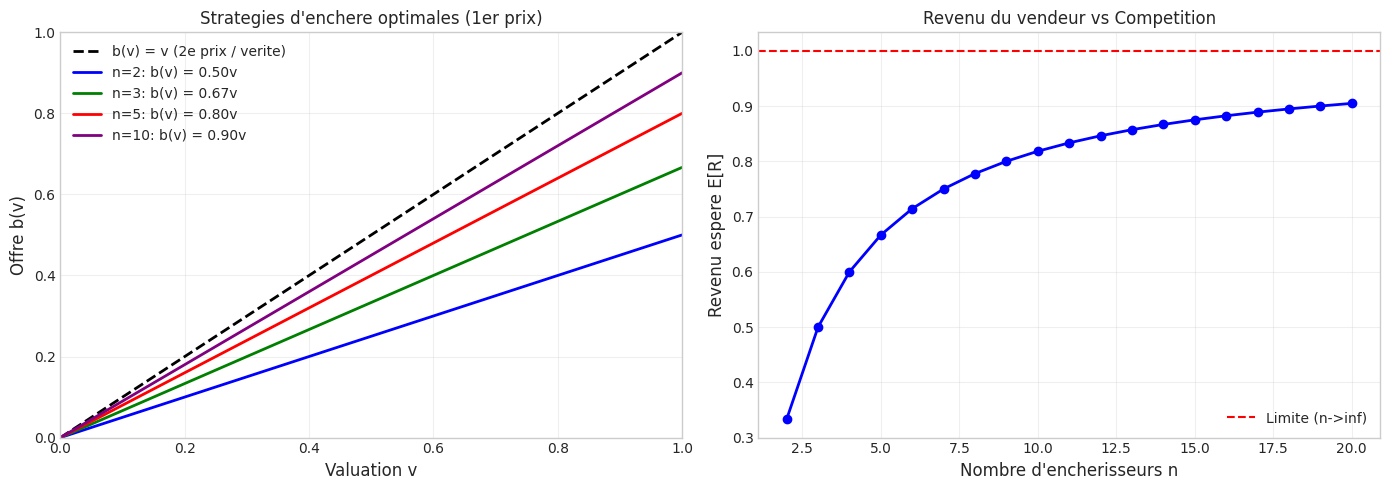

In [10]:
# Visualisation des strategies d'enchere

def visualize_bidding_strategies():
    """Visualise les strategies d'enchere optimales."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    v = np.linspace(0, 1, 100)
    
    # Gauche: Strategies
    ax1 = axes[0]
    ax1.plot(v, v, 'k--', label='b(v) = v (2e prix / verite)', linewidth=2)
    
    for n, color in [(2, 'blue'), (3, 'green'), (5, 'red'), (10, 'purple')]:
        b = (n-1)/n * v
        ax1.plot(v, b, color=color, label=f'n={n}: b(v) = {(n-1)/n:.2f}v', linewidth=2)
    
    ax1.set_xlabel('Valuation v', fontsize=12)
    ax1.set_ylabel('Offre b(v)', fontsize=12)
    ax1.set_title('Strategies d\'enchere optimales (1er prix)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Droite: Revenu espere en fonction de n
    ax2 = axes[1]
    n_range = np.arange(2, 21)
    revenues = (n_range - 1) / (n_range + 1)
    
    ax2.plot(n_range, revenues, 'b-', linewidth=2, marker='o')
    ax2.axhline(1, color='r', linestyle='--', label='Limite (n->inf)')
    
    ax2.set_xlabel('Nombre d\'encherisseurs n', fontsize=12)
    ax2.set_ylabel('Revenu espere E[R]', fontsize=12)
    ax2.set_title('Revenu du vendeur vs Competition', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_bidding_strategies()

## 6. Introduction aux Jeux de Signaling

### 6.1 Structure

Dans un **jeu de signaling**:
1. **Nature** tire le type de l'Emetteur (Sender)
2. L'Emetteur observe son type et envoie un **signal** (message)
3. Le Receveur (Receiver) observe le signal et choisit une **action**
4. Les gains dependent du type ET du signal ET de l'action

### 6.2 Types d'Equilibres

| Equilibre | Description |
|-----------|-------------|
| **Separateur** | Chaque type envoie un signal different |
| **Pooling** | Tous les types envoient le meme signal |
| **Semi-separateur** | Certains types se distinguent, d'autres se melanent |

In [11]:
def spence_signaling_model():
    """
    Modele de signaling de Spence (1973) - Education.
    
    - Travailleurs ont une productivite theta in {L, H}
    - L'education e est un signal couteux
    - Cout de l'education: c(e, theta) = e / theta (plus facile pour theta eleve)
    - Les employeurs observent e mais pas theta
    - Salaire = productivite esperee
    """
    print("Modele de Signaling de Spence (Education)")
    print("="*60)
    
    theta_L = 1  # Productivite basse
    theta_H = 2  # Productivite haute
    p = 0.5  # Proba type H
    
    print(f"\nProductivites: theta_L = {theta_L}, theta_H = {theta_H}")
    print(f"Proba(type H) = {p}")
    print(f"Cout education: c(e, theta) = e / theta")
    
    print("\n" + "="*60)
    print("\nEquilibre Pooling:")
    print("  - Tous les types choisissent e = 0")
    print(f"  - Salaire = E[theta] = {p}*{theta_H} + {1-p}*{theta_L} = {p*theta_H + (1-p)*theta_L}")
    print("  - Gain type L: 1.5 - 0 = 1.5")
    print("  - Gain type H: 1.5 - 0 = 1.5")
    print("  -> Pas de separation: les H subventionnent les L!")
    
    print("\n" + "="*60)
    print("\nEquilibre Separateur (si possible):")
    print("  - Type H choisit e* > 0, Type L choisit e = 0")
    print("  - Condition de separation:")
    print("    * Type L ne veut pas imiter: theta_H - e*/theta_L <= theta_L")
    print(f"      -> e* >= {theta_H - theta_L} = 1")
    print("    * Type H veut signaler: theta_H - e*/theta_H >= theta_L")
    print(f"      -> e* <= {theta_H * (theta_H - theta_L)} = 2")
    print("\n  -> Pour 1 <= e* <= 2, equilibre separateur:")
    print("     Type H: e* in [1,2], salaire = 2, gain = 2 - e*/2")
    print("     Type L: e = 0, salaire = 1, gain = 1")
    
    # Verification
    e_star = 1  # Niveau minimal pour separation
    gain_L_pooling = p*theta_H + (1-p)*theta_L
    gain_L_separating = theta_L
    gain_H_pooling = p*theta_H + (1-p)*theta_L
    gain_H_separating = theta_H - e_star/theta_H
    
    print("\n" + "="*60)
    print(f"\nComparaison des gains (e* = {e_star}):")
    print(f"  Type L: Pooling = {gain_L_pooling}, Separateur = {gain_L_separating}")
    print(f"  Type H: Pooling = {gain_H_pooling}, Separateur = {gain_H_separating}")
    print(f"\n  -> Le type H prefere separer? {gain_H_separating > gain_H_pooling}")
    print(f"  -> L'education est un signal 'couteux' mais efficace!")

spence_signaling_model()

Modele de Signaling de Spence (Education)

Productivites: theta_L = 1, theta_H = 2
Proba(type H) = 0.5
Cout education: c(e, theta) = e / theta


Equilibre Pooling:
  - Tous les types choisissent e = 0
  - Salaire = E[theta] = 0.5*2 + 0.5*1 = 1.5
  - Gain type L: 1.5 - 0 = 1.5
  - Gain type H: 1.5 - 0 = 1.5
  -> Pas de separation: les H subventionnent les L!


Equilibre Separateur (si possible):
  - Type H choisit e* > 0, Type L choisit e = 0
  - Condition de separation:
    * Type L ne veut pas imiter: theta_H - e*/theta_L <= theta_L
      -> e* >= 1 = 1
    * Type H veut signaler: theta_H - e*/theta_H >= theta_L
      -> e* <= 2 = 2

  -> Pour 1 <= e* <= 2, equilibre separateur:
     Type H: e* in [1,2], salaire = 2, gain = 2 - e*/2
     Type L: e = 0, salaire = 1, gain = 1


Comparaison des gains (e* = 1):
  Type L: Pooling = 1.5, Separateur = 1
  Type H: Pooling = 1.5, Separateur = 1.5

  -> Le type H prefere separer? False
  -> L'education est un signal 'couteux' mais efficace!


## 7. Exercices

### Exercice 1: Bertrand avec Incertitude

Duopole de Bertrand ou chaque firme ne connait que son propre cout.
- Couts: $c_i \in \{1, 2\}$ avec $P(c_i=1) = 0.5$
- Prix: $p_i \geq c_i$
- Demande: le prix le plus bas capte tout le marche (partage si egalite)

Trouvez l'equilibre bayesien.

### Exercice 2: Enchere "All-Pay"

Enchere ou tous les participants paient leur offre (pas seulement le gagnant).
- Valuations $v_i \sim U[0,1]$
- Gain gagnant: $v_i - b_i$
- Gain perdant: $-b_i$

Trouvez la strategie d'equilibre.

### Exercice 3: Selection Adverse

Marche de voitures d'occasion (Akerlof):
- Qualite $q \sim U[0,1]$
- Vendeur connait $q$, acheteur non
- Valeur pour vendeur: $q$, pour acheteur: $1.5q$

Analysez l'equilibre de marche.

In [12]:
# Espace pour vos solutions

# Exercice 1: Bertrand bayesien
def solve_bertrand_bayesian():
    """Resout le duopole de Bertrand avec couts incertains."""
    # A completer...
    pass

# Exercice 3: Selection adverse
def analyze_adverse_selection():
    """Analyse le marche des lemons d'Akerlof."""
    print("Marche des Lemons (Akerlof, 1970)")
    print("="*50)
    
    # Supposons un prix de marche P
    # Vendeurs avec q <= P vendent (car ils obtiennent plus que leur valuation)
    # Qualite moyenne des voitures offertes: E[q | q <= P] = P/2
    # Valeur pour acheteur: 1.5 * P/2 = 0.75 * P
    # Acheteur pret a payer: 0.75 * P
    # Equilibre: P = 0.75 * P => P = 0
    
    print("\nRaisonnement:")
    print("  1. A prix P, seuls les vendeurs avec q <= P vendent")
    print("  2. Qualite moyenne offerte: E[q | q <= P] = P/2")
    print("  3. Valeur pour acheteur: 1.5 * P/2 = 0.75P")
    print("  4. Acheteur pret a payer: 0.75P < P")
    print("  5. Le marche s'effondre! (adverse selection)")
    print("\nConclusion: Seul P=0 est un equilibre - aucune transaction!")

analyze_adverse_selection()

Marche des Lemons (Akerlof, 1970)

Raisonnement:
  1. A prix P, seuls les vendeurs avec q <= P vendent
  2. Qualite moyenne offerte: E[q | q <= P] = P/2
  3. Valeur pour acheteur: 1.5 * P/2 = 0.75P
  4. Acheteur pret a payer: 0.75P < P
  5. Le marche s'effondre! (adverse selection)

Conclusion: Seul P=0 est un equilibre - aucune transaction!


## 8. Resume

| Concept | Description |
|---------|-------------|
| **Information incomplete** | Incertitude sur les caracteristiques du jeu |
| **Type** | Caracteristique privee d'un joueur |
| **Prior commun** | Distribution des types connue de tous |
| **BNE** | Nash ou chaque type maximise son gain espere |
| **Signaling** | Communication couteuse revelant l'information |

### Points cles

- La transformation de **Harsanyi** convertit info incomplete en imparfaite
- En **Cournot bayesien**, l'incertitude affecte les quantites
- Les **encheres** illustrent l'interaction strategique sous incertitude
- Le **signaling** permet la revelation credible d'information privee

### Prochaine etape

**Notebook 11 : Jeux de Reputation** - Construction de reputation, cheap talk, et modele de Kreps-Wilson.